# Imports

In [1]:
#!pip install pybaseball

from pybaseball import statcast, statcast_batter, playerid_lookup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import unidecode
from datetime import datetime

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

from scipy.stats import multivariate_normal
from scipy.spatial.distance import mahalanobis


from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances_argmin_min


import math
import warnings
warnings.filterwarnings('ignore')

In [28]:
data2021_query = statcast('2021-04-01', '2021-10-03', parallel = True)
data2022_query = statcast('2022-03-31', '2022-10-02', parallel = True)
# data2023 = statcast('2023-03-30', '2023-10-01', parallel = True)

#data2021 = pd.read_csv('Data/Statcast/statcast21.csv', low_memory = False)
#data2022 = pd.read_csv('Data/Statcast/statcast22.csv', low_memory = False)

This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 186/186 [01:49<00:00,  1.69it/s]


This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 186/186 [01:56<00:00,  1.60it/s]


In [186]:
data2023 = statcast('2023-03-30', '2023-10-01', parallel = True)
data2023.to_csv('statcast23.csv',index=False)

This is a large query, it may take a moment to complete


100%|█████████████████████████████████████████| 186/186 [03:05<00:00,  1.00it/s]


# Cleaning

## Eliminating Position Players

In [37]:
sorted_names = data2021_query.player_name.value_counts(sort=True).index
pitch_totals = data2021_query.player_name.value_counts(sort=True)

#for i,j in zip(sorted_names,pitch_totals):
#    if j <= 150:
#        print(i,j)

In [1]:
# Names of position players to leave out of dataset
names = "".join(["Blandino, Alex,León, Sandy,Sogard, Eric,Astudillo, Willians,Peterson, Jace,Torreyes, Ronald,Mercedes, Yermín,",
         "Castro, Harold,Peralta, David,Almora Jr., Albert,Mejía, Francisco,Drury, Brandon,Tauchman, Mike,Burns, Andy,",
         "Phillips, Brett,Eaton, Adam,Bemboom, Anthony,Ruf, Darin,Maile, Luke,Tom, Ka'ai,Luplow, Jordan,Plawecki, Kevin,",
        "Rogers, Jake,Reddick, Josh,Moreland, Mitch,Cabrera, Asdrúbal,Guillorme, Luis,Holaday, Bryan,Pérez, Hernán,",
         "Wilkerson, Stevie,Arroyo, Christian,Rizzo, Anthony,Romine, Andrew,Mendick, Danny,Schrock, Max,",
         "Culberson, Charlie,Araúz, Jonathan,Gonzalez, Marwin,Turner, Justin,Robertson, Daniel,Holt, Brock,",
         "Mathisen, Wyatt,Wynns, Austin,Lopez, Nicky,Moran, Brian,Owings, Chris,Reyes, Pablo,Difo, Wilmer,",
        "Fuentes, Joshua,Valaika, Pat,Cronenworth, Jake,Pillar, Kevin,Slater, Austin,Evans, Phillip,Duffy, Matt,",
        "Alcántara, Sergio,Knapp, Andrew,Freeman, Mike,Gonzalez, Romy,Maton, Nick,Mayfield, Jack,Alberto, Hanser,",
        "Clemens, Kody,González, Luis,Gordon, Nick,VanMeter, Josh,Bethancourt, Christian,Brosseau, Mike,Myers, Wil,",
        "Clement, Ernie,Schwindel, Frank,Molina, Yadier,Taylor, Michael A.,Neuse, Sheldon,Strange-Gordon, Dee,",
        "McKenna, Ryan,Bradley Jr., Jackie,Pujols, Albert,Freeman, Caleb,Pinder, Chad,Chang, Yu,Batten, Matthew,",
        "Simmons, Andrelton,Escobar, Alcides,Dozier, Hunter,Walton, Donovan,Reynolds, Matt,Torrens, Luis,Dickerson, Corey,",
         "Barnhart, Tucker,Caratini, Victor,Merrifield, Whit,Adrianza, Ehire,Knizner, Andrew,Grichuk, Randal,Serven, Brian,",
        "Palacios, Jermaine,McGuire, Reese,Vargas, Ildemaro,Hall, Darick,Gosselin, Phil,Nogowski, John,Stubbs, Garrett,",
        "Sánchez, Yolmer,Arcia, Orlando,Ford, Mike,Hager, Jake,Harrison, Josh,Kelly, Carson,Lopez, Alejo,",
        "Carpenter, Matt,Reyes, Franmil,García, Robel"]).split(',')

# Join concatted string into array of names as they appear in Statcast name column
pos_players = [x+ ',' +y for x,y in zip(names[0::2], names[1::2])]

In [4]:
pos_players

['Blandino, Alex',
 'León, Sandy',
 'Sogard, Eric',
 'Astudillo, Willians',
 'Peterson, Jace',
 'Torreyes, Ronald',
 'Mercedes, Yermín',
 'Castro, Harold',
 'Peralta, David',
 'Almora Jr., Albert',
 'Mejía, Francisco',
 'Drury, Brandon',
 'Tauchman, Mike',
 'Burns, Andy',
 'Phillips, Brett',
 'Eaton, Adam',
 'Bemboom, Anthony',
 'Ruf, Darin',
 'Maile, Luke',
 "Tom, Ka'ai",
 'Luplow, Jordan',
 'Plawecki, Kevin',
 'Rogers, Jake',
 'Reddick, Josh',
 'Moreland, Mitch',
 'Cabrera, Asdrúbal',
 'Guillorme, Luis',
 'Holaday, Bryan',
 'Pérez, Hernán',
 'Wilkerson, Stevie',
 'Arroyo, Christian',
 'Rizzo, Anthony',
 'Romine, Andrew',
 'Mendick, Danny',
 'Schrock, Max',
 'Culberson, Charlie',
 'Araúz, Jonathan',
 'Gonzalez, Marwin',
 'Turner, Justin',
 'Robertson, Daniel',
 'Holt, Brock',
 'Mathisen, Wyatt',
 'Wynns, Austin',
 'Lopez, Nicky',
 'Moran, Brian',
 'Owings, Chris',
 'Reyes, Pablo',
 'Difo, Wilmer',
 'Fuentes, Joshua',
 'Valaika, Pat',
 'Cronenworth, Jake',
 'Pillar, Kevin',
 'Slater, A

In [42]:
# Group by statements to find # pitches and velocity numbers for position players
"""data21_grps = data2021_query.groupby('player_name').agg(max_velo =('release_speed', np.max),
                                               med_velo =('release_speed', np.median),
                                               avg_velo =('release_speed', np.mean),
                                               num_pitches = ('player_name', np.count_nonzero))
data22_grps = data2022_query.groupby('player_name').agg(max_velo =('release_speed', np.max),
                                               med_velo =('release_speed', np.median),
                                               avg_velo =('release_speed', np.mean),
                                               num_pitches = ('player_name', np.count_nonzero))

data21_grps['Max-Avg Diff'] = data21_grps['max_velo'] - data21_grps['avg_velo']
data22_grps['Max-Avg Diff'] = data22_grps['max_velo'] - data22_grps['avg_velo']
"""
# Filter out to find all position players

"""
data21_grps[((data21_grps.num_pitches <= 200) & (data21_grps['med_velo'] < 85)) |
            ((data21_grps.num_pitches <= 200) & (data21_grps['Max-Avg Diff'] > 12))|
           ((data21_grps.num_pitches <= 200) & (data21_grps['max_velo'] < 90))]

data22_grps[((data22_grps.num_pitches <= 200) & (data22_grps['med_velo'] < 85)) |
            ((data22_grps.num_pitches <= 200) & (data22_grps['Max-Avg Diff'] > 12))|
           ((data21_grps.num_pitches <= 200) & (data21_grps['max_velo'] < 90))]
"""

"\ndata21_grps[((data21_grps.num_pitches <= 200) & (data21_grps['med_velo'] < 85)) |\n            ((data21_grps.num_pitches <= 200) & (data21_grps['Max-Avg Diff'] > 12))|\n           ((data21_grps.num_pitches <= 200) & (data21_grps['max_velo'] < 90))]\n\ndata22_grps[((data22_grps.num_pitches <= 200) & (data22_grps['med_velo'] < 85)) |\n            ((data22_grps.num_pitches <= 200) & (data22_grps['Max-Avg Diff'] > 12))|\n           ((data21_grps.num_pitches <= 200) & (data21_grps['max_velo'] < 90))]\n"

In [35]:
data2021_query.shape, data2022_query.shape

((709852, 92), (712392, 92))

In [44]:
#(Recursively) Eliminate position players from dataset, update dataset
data21_pits = data2021_query[~data2021_query.player_name.isin(pos_players)]
data22_pits = data2022_query[~data2022_query.player_name.isin(pos_players)]

In [24]:
# Save first-pass cleaned data to CSV

## NA Values

In [134]:
# Define a function to fill NaN values within groups
def fillna_by_pitcher(df, cols, types):
    '''
    Description: Fills NA values (pitch metrics), applied by pitch type per pitcher
    --------------------------------------------------------------------------------
    Inputs: df, cols
    
    Returns: df
        NA columns filled
    '''

    
    # For each column, take mean of column within dataframe, fill NA values with mean
    for i in cols:

        mean = df[i].mean(skipna= True).astype(types[i])
        #print(i, mean)
        
        df[i].fillna(mean,inplace = True)
    
    return df

In [144]:
def clean_train_data(df):
    '''
    Description: Cleans training data, filters dataframe for relevant features, 
    removes non-pitches and fills in NA values for each unique pitch for all pitchers
    --------------------------------------------------------------------------------
    Inputs: df
    
    Returns: df_clean
        Cleaned input df
    '''
    # Define relevant feature columns, values to remove, columns with NA values to fill
    non_pitches = ['FA','PO','EP','CS']
    
    y = ['delta_run_exp']
    
    y_cats = ['description','bb_type']
    
    context_features = ['game_pk','game_date','player_name','batter', 'pitch_type',
                        'at_bat_number','pitch_number',
                        'home_team','p_throws','stand',
                        'balls','strikes','sz_top', 'sz_bot']
    # do not inlcude baserunners for GIDPs
    
    cont_features = ['release_speed','release_extension','effective_speed','release_spin_rate',
            'release_pos_x', 'release_pos_y', 'release_pos_z','spin_axis', 'pfx_x', 'pfx_z',
            'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'plate_x', 'plate_z',
            'launch_speed','launch_angle', 'hc_x','hc_y']
    
    
    features = y + y_cats + context_features + cont_features
    
    # Drop later: game_pk, player_name, batter, game_date, at_bat_number, pitch_number

    # Filter Dataframe for features
    df = df[features]
    
    # Remove pitchouts/non-pitches, pitches with 0 movement (Statcast errors)
    print("Number of Statcast Errors Removed:",
        df[(df.pitch_type.isin(non_pitches)) | ((df.pfx_x == 0.0) & (df.pfx_z == 0.0))].shape[0])
    
    df_filt = df[(~df.pitch_type.isin(non_pitches)) & ((df.pfx_x != 0.0) & (df.pfx_z != 0.0))]
    """
    # Define columns to fill or drop if NA
    fill_cols = ['release_speed','release_extension','effective_speed','release_spin_rate',
                 'release_pos_x','release_pos_y','release_pos_z','spin_axis']

    fill_dtypes = {'release_speed': 'float64',
                   'release_extension': 'float64',
                   'effective_speed': 'float64',
                   'release_spin_rate': 'int64',
                 'release_pos_x': 'float64',
                   'release_pos_y': 'float64',
                   'release_pos_z': 'float64',
                   'spin_axis':'int64'} 
    
    
    
    # Fill in NA values for each pitch and pitcher with mean of each column for each unique
    

    df_filled = df_filt.groupby(['player_name','pitch_type']).apply(
        fillna_by_pitcher, cols = fill_cols, types = fill_dtypes)
    """

    na_cols = ['delta_run_exp','pitch_number','pfx_x','pfx_z',
               'release_pos_x', 'release_pos_y', 'release_pos_z', 
               'release_speed','release_extension','effective_speed','release_spin_rate',
               'spin_axis','sz_top', 'sz_bot']
    
    df_clean = df_filt.dropna(subset=na_cols)
    
    # get rid of bad values of description/bb_type
    df_clean = df_clean[(~((df_clean.description == 'hit_into_play') & (df_clean.bb_type.isna()))) | 
                        ( (df_clean.bb_type.notna()) & 
                         ( (df_clean.launch_speed.notna()) & (df_clean.launch_angle.notna()) ) 
                        )]
    
    df_clean = df_clean.replace('foul_tip','swinging_strike').replace(
    'swinging_strike_blocked','swinging_strike').replace('blocked_ball','ball').replace(
    'missed_bunt','swinging_strike').replace('bunt_foul_tip','swinging_strike').replace(
        'foul_bunt','foul')
    
    #df_clean = df_clean[~((df_clean.description == 'hit_into_play') & (df_clean.bb_type.isna()))]
    
    # OHC Base variables to 0 and 1
    #df_clean[['on_1b','on_2b','on_3b']] = df_clean[['on_1b','on_2b','on_3b']].notna().astype(int)

    # Sort dataframe by pitches in chronological order, return
    df_clean = df_clean.sort_values(['game_date','game_pk','at_bat_number','pitch_number'])
    return df_clean

In [158]:
def add_new_features(df, season_start):
    '''
    Description: Adds new features in dataframe
        - inferred_axis: Inferred Spin Axis (SSW Effects)
        - axis_diff: Difference of Inferred and Observed Spin Axis
        - game_week: Change game date to week of season depending on start date of season
        - pitch_count: Pitch # of outing for each outing per pitcher 
    --------------------------------------------------------------------------------
    Inputs: df, season_start (str)
    
    Returns: df
        Dataframe with new features added
    '''
    
    # inferred_axis: 180 / pi * atan(pfx_z / pfx_x) + 90 (where pfx_x is < 0, add 180 degrees.)
    df['inferred_axis'] = np.degrees(np.arctan(df['pfx_z'] / df['pfx_x'])) + 90
    df.loc[df['pfx_x'] < 0, 'inferred_axis'] += 180
    df['axis_diff'] = df['spin_axis'] - df['inferred_axis']
    
    # axis_diff: spin_axis - inferred_axis
    
    # Pitch Count: Cumulative pitch number of outing for pitcher
    df['pitch_count'] = df.sort_values(
    ['game_date','game_pk','at_bat_number','pitch_number']).groupby(
    ['game_date','game_pk','player_name']).cumcount() + 1
    
    # Create game_week column, where week of season is taken from game_date in Savant
    """
    start_date = datetime.strptime(season_start, '%Y-%m-%d').date()
    
    df['datetime'] = pd.to_datetime(df['game_date'])
    df['game_week'] = df.apply(lambda x: ((x['datetime'].date() - start_date).days // 7) + 1, axis = 1)
    df = df.drop('datetime',axis=1)
    """
    

    return df

In [159]:
data21_query_clean = clean_train_data(data2021_query)
data22_query_clean = clean_train_data(data2022_query)

Number of Statcast Errors Removed: 1368
Number of Statcast Errors Removed: 1910


In [160]:
data21 = add_new_features(data21_query_clean,'2021-04-01')
data22 = add_new_features(data22_query_clean,'2022-03-31')

# EDA

## Feature Exploration- Pitch Type Frequency

### Aggregate Counts, Cumulative Relative Frequency of Pitch Type Over Season

In [150]:
def plot_lineplot(dataset, xvar, yvar, hue_var):
    '''
    Description: Plots lineplot, adds labels of hue variable at end of each line
    --------------------------------------------------------------------------------
    Inputs: dataset, x_var, y_var, hue_var
    
    Returns: None
    '''
    plt.figure(figsize = (20,10))
    plot = sns.lineplot(data = dataset, x = xvar,y= yvar,hue = hue_var, palette = 'tab10')
    
    # Add labels to the lines, each at the last x-value and corresponding y-value 
    for line in plot.lines:
        x, y = line.get_data()
        
        if len(x) == 0 and len(y) == 0:
            pass
        else:
            label = dataset[dataset[yvar] == y[-1]][hue_var].values[-1]
            plt.text(x[-1], y[-1], label, ha='right', va='bottom', fontsize=12, color=line.get_color())

In [151]:
def get_aggregate_count(data, player, year, plot = True):
    '''
    Description: Aggregates data for all pitch_types, cumulative count for each date,
    plots lineplot of aggregate data with labels
    --------------------------------------------------------------------------------
    Inputs: data (dataframe), player (str), year (str/int), plot (boolean, default True)
    
    Returns: pitch_aggs (dataframe)
    '''
    # Reverses order of data, changes date to datetime type instead of str
    data = data[::-1].reset_index(drop=True)
    data['game_date'] = pd.to_datetime(data['game_date'])
    
    # Groups input data by pitch_type and game_date for each date 
    # (includes 0 for pitches not thrown on a specific day)
    pitch_aggs = pd.DataFrame(data.groupby(['pitch_type','game_date']).size().unstack(
     fill_value=0)).reset_index().melt(
        id_vars='pitch_type', var_name='game_date', value_name='count')
    
    #  Cumulatively sums pitch type counts ober each unique day
    pitch_aggs['Cumulative_Count'] = pitch_aggs.groupby('pitch_type')['count'].cumsum()
    
    # Plots lineplot for data if plot set to true
    if plot:
        plot_lineplot(pitch_aggs, 'game_date', 'Cumulative_Count', 'pitch_type')

        # Format the x-axis date labels (optional)
        plt.xticks(rotation=45)

        # Set labels and title
        plt.xlabel('Date')
        plt.ylabel('Aggregate Count')
        plt.title(f'Aggregate Counts by Pitch Type by Game Date, {player}, {year}', fontsize=16)

        # Show the legend
        plt.legend(title='Pitch Type',loc="upper left")

        # Display the plot
        plt.show()
    
    return pitch_aggs

In [152]:
def get_cumulative_freq(agg_data, player, year, plot = True):
    '''
    Description: Aggregates data for all pitch_types' cumulative relative frequency for each date,
    plots lineplot of aggregate data with labels
    --------------------------------------------------------------------------------
    Inputs: agg_data (dataframe), player (str), year (str/int), plot (boolean, default True)
    
    Returns: pitch_aggs (dataframe)
    '''
    
    # For each game_date, cumulatively sum number of pitches thrown to find relative frequencies
    pitch_total_sum = agg_data.groupby('game_date')['count'].sum().cumsum().reset_index(name = 'season_total')
    
    # Merges input data (of cumulative count for pitch types), finds cumulative relative frequency
    # for each game_date
    merged_freq_df = agg_data.merge(pitch_total_sum, on = 'game_date',how='left')
    merged_freq_df['Cumulative_Rel_Freq'] = merged_freq_df['Cumulative_Count'] / merged_freq_df['season_total']

    # Plots data on lineplot if plot set to True
    if plot:
        plot_lineplot(merged_freq_df, 'game_date', 'Cumulative_Rel_Freq','pitch_type')
        plt.xticks(rotation=45)

        # Set labels and title
        plt.xlabel('Date')
        plt.ylabel('Cumulative Relative Frequency')
        plt.title(f'Cumulative Relative Frequency of Pitch Type, {player}, {year}', fontsize=16)

        # Show the legend
        plt.legend(title='Pitch Type',loc="upper left")

        # Display the plot
        plt.show()
    
    return merged_freq_df

In [154]:
all21_aggregates = get_aggregate_count(data21, 'All', 2021)

In [ ]:
all21_rel_freq = get_cumulative_freq(all21_aggregates, 'All', 2021)

In [ ]:
all22_aggregates = get_aggregate_count(data22, 'All', 2022)

In [ ]:
all22_rel_freq = get_cumulative_freq(all22_aggregates, 'All', 2022)

#### Frequency by Handedness of Batter

In [ ]:
data21_rhb = data21[data21.stand == 'R']
data21_rhb_agg = get_aggregate_count(data21_rhb, 'All RHB', 2021, False)
data21_rhb_cumul = get_cumulative_freq(data21_rhb_agg, 'All RHB', 2021)

In [ ]:
data21_lhb = data21[data21.stand == 'L']
data21_lhb_agg = get_aggregate_count(data21_lhb, 'All LHB', 2021, False)
data21_lhb_cumul = get_cumulative_freq(data21_lhb_agg, 'All LHB', 2021)

### Relative Frequency per Day

In [ ]:
def get_relative_freq(data, player, year, plot = True):
    '''
    Description: Aggregates data for all pitch_types, finds relative frequency for each pitch  for each date,
    plots lineplot of aggregate data with labels
    --------------------------------------------------------------------------------
    Inputs: data (dataframe), player (str), year (str/int), plot (boolean, default True)
    
    Returns: pitch_aggs (dataframe)
    '''
    
    # Reorders data, changes game_date to type datetime
    data = data[::-1].reset_index(drop=True)
    data['game_date'] = pd.to_datetime(data['game_date'])

    # Aggregate, Reshape the DataFrame using melt
    rel_pitch_aggs = pd.DataFrame(data.groupby(['pitch_type','game_date']).size().unstack(
     fill_value=0)).reset_index().melt(id_vars='pitch_type', var_name='game_date', value_name='count')
    
    # Sort the DataFrame by 'pitch_type' and 'game_date' 
    rel_aggs_reshaped = rel_pitch_aggs.sort_values(by=['pitch_type', 'game_date']).reset_index(drop=True)
    
    # Get total pitches thrown for all game_dates
    total_pitches = data.groupby('game_date')['pitch_type'].count().reset_index(name='total')
    
    # Merge dataframes, calculate relative pitch frequency per day
    merged_df = rel_aggs_reshaped.merge(total_pitches, on='game_date', how='left')
    merged_df['Relative_Freq'] = merged_df['count'] / merged_df['total']
    
    # Plots lineplot if plot set to True
    if plot:
        plot_lineplot(merged_df, 'game_date','Relative_Freq','pitch_type')

        # Format the x-axis date labels (optional)
        plt.xticks(rotation=45)

        # Set labels and title
        plt.xlabel('Date')
        plt.ylabel('Relative Frequency')
        plt.title(f'Relative Pitch Frequencies by Pitch Type per Game Date, {player}, {year}', fontsize=16)

        # Show the legend
        plt.legend(title='Pitch Type',loc="upper left")

        # Display the plot
        plt.show()
    
    return merged_df

In [ ]:
all21_relative = get_relative_freq(data21, 'All','2021')

In [ ]:
all22_relative = get_relative_freq(data22, 'All','2022')

### Individual Case

#### Shohei Ohtani

In [ ]:
test_data = data21.copy()[::-1].reset_index(drop=True)

In [ ]:
ohtani = test_data[test_data.player_name == 'Ohtani, Shohei']

In [ ]:
ohtani_agg21 = get_aggregate_count(ohtani, 'Shohei Ohtani','2021')

In [ ]:
ohtani21_cumul_freq = get_cumulative_freq(ohtani_agg21, 'Shohei Ohtani', 2021)

In [ ]:
ohtani_rel21 = get_relative_freq(ohtani, 'Shohei Ohtani','2021')

#### Zack Wheeler

In [ ]:
wheeler = test_data[test_data.player_name == 'Wheeler, Zack']

In [ ]:
wheeler_agg21 = get_aggregate_count(wheeler, 'Zack Wheeler','2021', False)
wheeler_cumul_freq21 = get_cumulative_freq(wheeler_agg21,'Zack Wheeler', 2021)

In [ ]:
wheeler_rel21 = get_relative_freq(wheeler, 'Zack Wheeler',' 2021')

In [ ]:
wheeler_lhb21 = wheeler[wheeler.stand == 'L']
wheeler_rhb21 = wheeler[wheeler.stand == 'R']

wheeler_rhb_agg21 = get_aggregate_count(wheeler_rhb21, 'Zack Wheeler (RHB)','2021', False)
wheeler_rhb21_cumul = get_cumulative_freq(wheeler_rhb_agg21,'Zack Wheeler (RHB)', 2021)

In [ ]:
wheeler_lhb_agg21 = get_aggregate_count(wheeler_lhb21, 'Zack Wheeler (LHB)','2021', False)
wheeler_lhb21_cumul = get_cumulative_freq(wheeler_lhb_agg21,'Zack Wheeler (LHB)', 2021)

### Cumulative Relative Frequency: *Pitcher vs. Batter (per AB), Pitcher vs. Batter (per Game)*

In [ ]:
# Get cumulative number pitches per AB for all unique ABs
pitch_counts_ab = data21.sort_values(
    ['game_date','game_pk','at_bat_number','pitch_number']).groupby(
    ['game_date','game_pk','player_name','at_bat_number']).cumcount() + 1

# Get cumulative number pitches per AB for each unique pitch, AB
pitch_type_counts_ab = data21.sort_values(
    ['game_date','game_pk','at_bat_number','pitch_number']).groupby(
    ['game_date','game_pk','player_name','at_bat_number','pitch_type']).cumcount() + 1

In [ ]:
# Plot histogram of each pitch's cumulative frequency within each unique AB
sns.histplot(pitch_type_counts_ab/pitch_counts_ab)
plt.title('Cumulative Relative Frequency of Pitches per AB per Game')

In [ ]:
# Get cumulative number pitches per AB for all unique batter v. pitcher matchup per game
pitch_counts_hitvpitch = data21.sort_values(
    ['game_date','game_pk','at_bat_number','pitch_number']).groupby(
    ['game_date','game_pk','player_name','batter']).cumcount() + 1

# Get cumulative number pitches per AB for all unique batter v. pitcher matchup per game for each unique pitch
pitch_type_counts_hitvpitch = data21.sort_values(
    ['game_date','game_pk','at_bat_number','pitch_number']).groupby(
    ['game_date','game_pk','player_name','batter','pitch_type']).cumcount() + 1

In [ ]:
# Plot histogram of each pitch's cumulative frequency within each unique batter v. pitcher matchup per game

sns.histplot(pitch_type_counts_hitvpitch/pitch_counts_hitvpitch)
plt.title('Cumulative Relative Frequency of Pitches per Hitter v. Pitcher Matchup per Game')

### Cumulative Relative Frequency *per Outing* - 2021

In [ ]:
# Get cumulative number pitches for all unique pitcher outings (start, relief)
pitch_counts = data21.sort_values(
    ['game_date','game_pk','at_bat_number','pitch_number']).groupby(
    ['game_date','game_pk','player_name']).cumcount() + 1

# Get cumulative number pitches  for all unique pitcher outings, for each unique pitch
pitch_type_counts = data21.sort_values(
    ['game_date','game_pk','at_bat_number','pitch_number']).groupby(
    ['game_date','game_pk','player_name','pitch_type']).cumcount() + 1

In [ ]:
# Plot cumulative relative frequency for all pitches for each unique pitcher appearance
sns.histplot(pitch_type_counts/pitch_counts)
plt.title('Cumulative Relative Frequency of Pitches per Outing')

## Feature Exploration: Velocity, Movement Differentials
### Added *after* pitch classifications from clustering analysis

In [14]:
#data2023 = statcast('2023-03-30', '2023-10-01', parallel = True)
#data2023.to_csv('statcast23.csv',index=False)

In [161]:
# Groups data by each game_date and pitcher, finds primary fastball 
# (or primary pitch if no fastball)
primary_fb = data21.groupby(['game_date','game_pk','player_name']).agg({
    'pitch_type': lambda x: x[x.isin(['FC','SI','FF'])].value_counts().idxmax() 
    if any(x.isin(['FC','SI','FF'])) 
    else x.value_counts().idxmax()
}).rename(columns={'pitch_type':'primary_pitch'})

In [164]:
# Merges training data with primary fastball, defines new columns of primary_pitch
primary_fb_data = data21.merge(primary_fb.reset_index(), left_on=['game_date','game_pk','player_name','pitch_type'], 
             right_on=['game_date','game_pk','player_name','primary_pitch'], how='inner')

In [166]:
# Define velocity, movement variables to calculate differentials from primary pitch
velo_mvt_cols = ['release_speed','release_spin_rate','pfx_x', 'pfx_z', 
                 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'spin_axis', 'inferred_axis','axis_diff',
                "release_pos_x","release_pos_y","release_pos_z"]

# Calculates mean for velocity, movement variables for each primary pitch for each pitcher per outing
primary_fb_means = primary_fb_data.groupby(['game_date','game_pk','player_name','pitch_type']).agg({
    i: 'mean' for i in velo_mvt_cols}).rename(columns = {
    i: i + '_mean' for i in velo_mvt_cols
}).reset_index()
primary_fb_means = primary_fb_means.rename(columns={'pitch_type':'primary_pitch'})

# Merges training data with primary pitch mean data
data21_merged = data21.merge(primary_fb_means, on = ['game_date','game_pk','player_name'], how = 'inner')

In [168]:
# Calculates all differentials for velocity and movenent profiles, release point
data21_merged['release_x_diff'] = data21_merged['release_pos_x'] - data21_merged['release_pos_x_mean']
data21_merged['release_y_diff'] = data21_merged['release_pos_y'] - data21_merged['release_pos_y_mean']
data21_merged['release_z_diff'] = data21_merged['release_pos_z'] - data21_merged['release_pos_z_mean']
data21_merged['velo_diff'] = data21_merged['release_speed'] - data21_merged['release_speed_mean']
data21_merged['spin_rate_diff'] = data21_merged['release_spin_rate'] - data21_merged['release_spin_rate_mean']
data21_merged['pfx_x_diff'] = data21_merged['pfx_x'] - data21_merged['pfx_x_mean']
data21_merged['pfx_z_diff'] = data21_merged['pfx_z'] - data21_merged['pfx_z_mean']
data21_merged['vx0_diff'] = data21_merged['vx0'] - data21_merged['vx0_mean']
data21_merged['vy0_diff'] = data21_merged['vy0'] - data21_merged['vy0_mean']
data21_merged['vz0_diff'] = data21_merged['vz0'] - data21_merged['vz0_mean']
data21_merged['ax_diff'] = data21_merged['ax'] - data21_merged['ax_mean']
data21_merged['ay_diff'] = data21_merged['ay'] - data21_merged['ay_mean']
data21_merged['az_diff'] = data21_merged['az'] - data21_merged['az_mean']
data21_merged['spin_axis_diff'] = data21_merged['spin_axis'] - data21_merged['spin_axis_mean']
data21_merged['inferred_axis_diff'] = data21_merged['inferred_axis'] - data21_merged['inferred_axis_mean']
data21_merged['axis_diff_diff'] = data21_merged['axis_diff'] - data21_merged['axis_diff_mean']


# Drops all primary pitch velocity, movement mean columns
data21_merged = data21_merged.drop(['primary_pitch'] + [i + '_mean' for i in velo_mvt_cols],axis = 1)

## Feature Exploration: "Noise" of Pitch Metrics

### To be applied *after* clustering pitches for pitch classifications

In [170]:
# For "noise" around pitch trajectory, calculate a multivariate normal distribution
# for each unique pitch thrown for each pitcher over a season

# Note: Calculating multivariate distributions for eachn pitch per game is 
# both extremely computationally intensive, and each distribution unstable due to small samples
# of each pitch per game

# Note: Does not include axis_diff for this iteration

# Define all continuous features 
cont_feats = ['release_speed','release_extension','effective_speed',
'release_spin_rate','release_pos_x', 'release_pos_y', 'release_pos_z',
'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'spin_axis','inferred_axis','axis_diff']

def multivariate_normal_distribution(x):
    '''
    Description: Applied to each group, calculate multivariate normal distribution
    for each row's continuous features with mean and covariance matrix
    --------------------------------------------------------------------------------
    Inputs: x (dataframe row, Series)
    
    Returns: mvn_dist, SciPy multivariate normal distribution
    '''
    
    # Extract the continuous variables
    continuous_vars = x[cont_feats]  
    
    # Calculate the mean and covariance matrix for the continuous variables
    mean = continuous_vars.mean()
    cov_matrix = continuous_vars.cov().fillna(0) + (np.eye(continuous_vars.cov().shape[0]) * 1e-6)
    
    # Create a multivariate normal distribution object
    mvn_dist = multivariate_normal(mean=mean, cov=cov_matrix, allow_singular=True)
    
    return mvn_dist

# Applies multivariate normal to all unique pitches for each pitcher per year(> 3000 pitches per year)
pitch_noise_groups = data21.groupby(['player_name','pitch_type']).apply(
    multivariate_normal_distribution).reset_index(name = 'MV_Dist')


In [172]:
def calc_mahalanobis(x):
    '''
    Description: Calculates mahalanobis distance of each pitch's continuous features
    from center, inverse covariance matrix of distribution
    --------------------------------------------------------------------------------
    Inputs: x (type Series)
    
    Returns: mahalanobis_distance (type float)
    '''
    # Defines distribution, continuous features
    distribution = x[-1]
    data = np.array(x[:-1])
    
    # Calculates distance
    mahalanobis_distance= mahalanobis(data, distribution.mean, np.linalg.inv(distribution.cov))
    return mahalanobis_distance

In [173]:
# Merges dataframes of training data, dataframe with multivariate distributions,
# so each unique pitch's distribution included in column for each pitch in training data
data21_merged2 = data21.merge(pitch_noise_groups, on = ['player_name','pitch_type'], how = 'inner')

# Calculate mahalanobis distance for all unique pitch's continuous features based on 
# center and inverse covariance matrix of each pitch's multivariate distribution
data21_merged2['mahalanobis'] = data21_merged2[cont_feats + ['MV_Dist']].apply(
    calc_mahalanobis, axis = 1)

# Drops all multivariate normal distributions
data21_merged2 = data21_merged2.drop('MV_Dist',axis = 1)
data21_merged2

,delta_run_exp,description,bb_type,game_pk,game_date,player_name,batter,pitch_type,at_bat_number,pitch_number,...,plate_x,plate_z,launch_speed,launch_angle,hc_x,hc_y,inferred_axis,axis_diff,pitch_count,mahalanobis
0,-0.049,foul,NaN,634615,2021-04-01,"Márquez, Germán",605141,FF,1,2,...,0.19,2.6,77.7,39,<NA>,<NA>,195.859366,-0.859366,1,10.458524
1,0.052,ball,NaN,634615,2021-04-01,"Márquez, Germán",605141,FF,1,3,...,-0.61,3.65,<NA>,<NA>,<NA>,<NA>,206.029592,1.970408,2,2.916350
2,-0.077,called_strike,NaN,634615,2021-04-01,"Márquez, Germán",605141,FF,1,5,...,0.07,3.09,<NA>,<NA>,<NA>,<NA>,191.181754,20.818246,3,3.403854
3,0.701,hit_into_play,line_drive,634615,2021-04-01,"Márquez, Germán",608369,FF,2,1,...,-0.15,2.49,96.3,8,65.34,122.03,196.898649,19.101351,5,3.641072
4,-0.109,foul,NaN,634615,2021-04-01,"Márquez, Germán",457759,FF,3,2,...,-0.33,1.6,74.5,-23,<NA>,<NA>,232.284024,-30.284024,7,6.583423
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701608,0.0,foul,NaN,632246,2021-10-03,"Domínguez, Seranthony",571918,SL,50,5,...,0.73,1.7,<NA>,<NA>,<NA>,<NA>,103.781597,-0.781597,7,1.500000
701609,-0.114,swinging_strike,NaN,632246,2021-10-03,"Domínguez, Seranthony",571918,SL,50,6,...,0.79,2.01,<NA>,<NA>,<NA>,<NA>,96.458816,-22.458816,8,1.500000
701610,0.024,ball,NaN,632246,2021-10-03,"Domínguez, Seranthony",663743,SL,51,2,...,0.89,0.83,<NA>,<NA>,<NA>,<NA>,81.304497,22.695503,10,1.500000
701611,0.043,ball,NaN,632246,2021-10-03,"Domínguez, Seranthony",663743,SL,51,5,...,-0.11,0.71,<NA>,<NA>,<NA>,<NA>,96.766175,8.233825,13,1.500000


In [183]:
data21_merged2.columns

Index(['delta_run_exp', 'description', 'bb_type', 'game_pk', 'game_date',
       'player_name', 'batter', 'pitch_type', 'at_bat_number', 'pitch_number',
       'home_team', 'p_throws', 'stand', 'balls', 'strikes', 'sz_top',
       'sz_bot', 'release_speed', 'release_extension', 'effective_speed',
       'release_spin_rate', 'release_pos_x', 'release_pos_y', 'release_pos_z',
       'spin_axis', 'pfx_x', 'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az',
       'plate_x', 'plate_z', 'launch_speed', 'launch_angle', 'hc_x', 'hc_y',
       'inferred_axis', 'axis_diff', 'pitch_count', 'mahalanobis'],
      dtype='object')

### Examples

Text(0.5, 1.0, 'Mahalanobis Distance by Pitch Type, Zack Wheeler 2021')

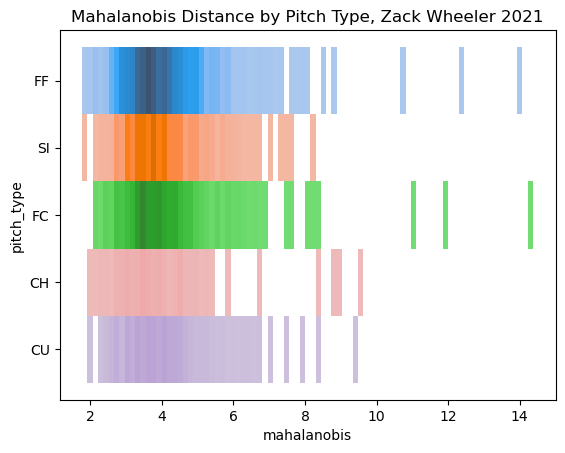

In [174]:
name = 'Wheeler, Zack'
wheeler_21 = data21_merged2[data21_merged2.player_name == name]

sns.histplot(
    wheeler_21, x="mahalanobis", y="pitch_type", hue="pitch_type", legend=False
)

plt.title(f'Mahalanobis Distance by Pitch Type, Zack Wheeler 2021')

Text(0.5, 1.0, 'Mahalanobis Distance by Pitch Type, Clayton Kershaw 2021')

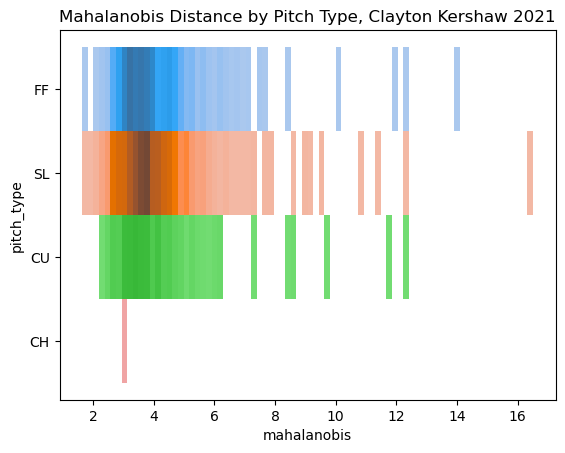

In [175]:
name = 'Kershaw, Clayton'
kershaw_21 = data21_merged2[data21_merged2.player_name == name]

sns.histplot(
    kershaw_21, x="mahalanobis", y="pitch_type", hue="pitch_type", legend=False
)

plt.title(f'Mahalanobis Distance by Pitch Type, Clayton Kershaw 2021')

Text(0.5, 1.0, 'Mahalanobis Distance by Pitch Type, Kenley Jansen 2021')

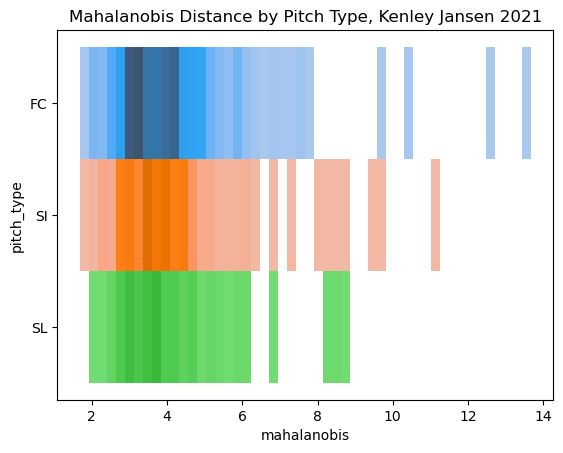

In [176]:
name = 'Jansen, Kenley'
jansen_21 = data21_merged2[data21_merged2.player_name == name]

sns.histplot(
    jansen_21, x="mahalanobis", y="pitch_type", hue="pitch_type", legend=False
)

plt.title(f'Mahalanobis Distance by Pitch Type, Kenley Jansen 2021')

Text(0.5, 1.0, 'Mahalanobis Distance by Pitch Type, Aroldis Chapman 2021')

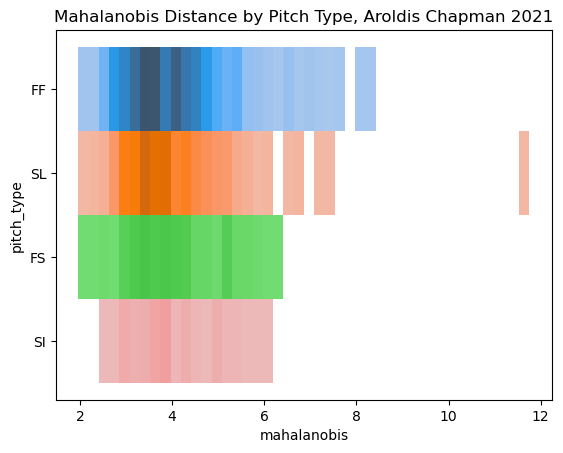

In [177]:
name = 'Chapman, Aroldis'
chapman_21 = data21_merged2[data21_merged2.player_name == name]

sns.histplot(
    chapman_21, x="mahalanobis", y="pitch_type", hue="pitch_type", legend=False
)

plt.title(f'Mahalanobis Distance by Pitch Type, Aroldis Chapman 2021')

# Pitch Classifications: Two-Seam vs. Sinker

# Clustering

### PCA Variance of Training Data

In [ ]:
# Define column transformer for different scalers
pca_scale_features = ['release_speed','release_extension','effective_speed',
                          'release_spin_rate','release_pos_x', 'release_pos_y', 'release_pos_z',
                          'spin_axis','axis_diff', 'inferred_axis', 'pfx_x', 'pfx_z',
                          'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot']

#pca_cat_features = ['p_throws','stand','pitch_number',
#    'home_team','game_week','balls','strikes','outs_when_up']

pca_preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), pca_scale_features), # StandardScaler for continuous features
        #('categorical', OneHotEncoder(), pca_cat_features) # OneHotEncoder for categorical features
    ])

# Define PCA as TruncatedSVD
pca_alldata = TruncatedSVD(n_components=10, random_state = 15)

# Create pipeline
pca_pipeline_alldata = Pipeline(steps=[
  ('preprocessor', pca_preprocessor),
  ('pca', pca_alldata)
])

# Concatenate all training data
# Apply PCA, plot variance for each of 10 principal components
all_data = pd.concat([data21, data22])

pca_pipeline_alldata.fit_transform(all_data)

# Plot the cumulative explained variance
variance = pca_pipeline_alldata.named_steps['pca'].explained_variance_ratio_

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(variance) + 1), variance)
plt.title('Elbow Plot, PCA Training Data')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.show()

### Clustering Scheme

In [ ]:
def create_scatterplot_subplot(input_data, x_vars, y_vars, hue_var, title = None, inp_ax = None):
    """
    Create a scatterplot with colors for categorical variables.
    Available to do multiple columns in a subplot or add a single plot to an existing figure.

    Parameters:
        df (DataFrame): The input DataFrame containing the data. (Filtered)
        x_vars (list of str): List of three variables for the x-axis.
        y_vars (list of str): List of three variables for the y-axis.
        hue_var (str): The variable for coloring the points.

    Returns: None 
    """
    # plot single scatterplot or multiple depending on number of variables passed
    if len(x_vars) == 1:
        
        sns.scatterplot(data= input_data, x=x_vars[0], 
                        y=y_vars[0], hue=hue_var, palette='Set1', ax = inp_ax)
        
        if inp_ax != None:
            inp_ax.set_title(title, fontsize=12)
    else:
        num_cols = len(x_vars)
        num_rows = 1  
        fig, axe = plt.subplots(num_rows, num_cols, figsize=(4*num_cols, 4))
        
        for i, (x_var, y_var) in enumerate(zip(x_vars, y_vars)):
            sns.scatterplot(data =input_data, x=x_var, y=y_var, hue=hue_var, palette='Set1',ax = axe[i])
            axe[i].set_title(f'{x_var} vs {y_var}')
            axe[i].set_xlabel(x_var)
            axe[i].set_ylabel(y_var)

In [ ]:
def cluster_pitchdata(name, pitch_data, df_out):
    """
    Do clustering analysis of pitch types for each unique pitcher,
    Determine appropriate # of clusters, choose to add new classifications or keep old ones

    Parameters:
        name (str): Name of pitcher
        pitch_data (pandas DataFrame): DataFrame of pitch data
        df_out (pandas DataFrame): DataFrame of pitch data with clustering analysis done

    Returns: df_out, df with clustering analysis done
    """
    
    # Define dataframe of pitch data for specific pitcher, ground-truth pitch classifications
    df = pitch_data[pitch_data.player_name == name].reset_index(drop=True)
    df_hue = df.pitch_type.reset_index(drop=True)
    df = df.drop(['player_name','pitch_type'],axis=1)
    #,'batter','game_pk','game_date'

    
    # Define the column transformer for different scalers
    standardscale_features = ['release_speed','release_extension','effective_speed',
                          'release_spin_rate','release_pos_x', 'release_pos_y', 'release_pos_z',
                          'spin_axis','inferred_axis','axis_diff','pfx_x', 'pfx_z',
                          'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot']

    preprocessor = ColumnTransformer(
    transformers=[
        ('standard_scale', StandardScaler(), standardscale_features), # StandardScaler for continuous features
    ])

    # Fit PCA to 4 components
    pca = TruncatedSVD(n_components=4, random_state = 15)

    # Create pipeline, fit
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', pca)
    ])

    df_pca = pd.DataFrame(pipeline.fit_transform(df), 
                          columns = ['PC1','PC2','PC3','PC4'])

    # Plot PCA data to determine number of clusters to fit to data
    xpca_vars = ['PC1'] #['PC1','PC2','PC3','PC4']
    ypca_vars = ['PC2'] #['PC2','PC3','PC4','PC1']

    plt.figure(figsize=(4,4))
    create_scatterplot_subplot(df_pca, xpca_vars, ypca_vars, df_hue)
    plt.title(f'PCA: {name}')
    plt.show()
    
    
    print('Before Clustering:', ', '.join([f"{index}: {count}" for index, count in df_hue.value_counts().items()]))
    
    # Fit Gaussian Mixture Model (GMM) to the reduced data
    num_clusters = int(input('Specify Number of Clusters: '))  # Specify the number of clusters
    
    gmm = GaussianMixture(n_components=num_clusters, n_init = 30, random_state=42, max_iter = 500, 
                      tol=1e-8,init_params = 'k-means++')
    cluster_labels = gmm.fit_predict(df_pca)

    # Add cluster labels back to the original data
    df['pitch_type'] = cluster_labels

    # Calculate cluster centroids
    cluster_centroids = gmm.means_

    # Calculate the centroids of ground truth labels
    ground_truth_centroids = []
    ground_truth_labels = np.unique(df_hue)

    for label in ground_truth_labels:
        centroid = np.mean(df_pca[np.array(df_hue) == label], axis=0)
        ground_truth_centroids.append(centroid)

    # Assign clusters to ground truth labels based on centroid mahalanobis distances
    cluster_to_ground_truth_mapping, _ = pairwise_distances_argmin_min(
    X= cluster_centroids, Y= ground_truth_centroids,
    metric='mahalanobis', 
        metric_kwargs={'VI': np.linalg.inv(np.cov(cluster_centroids.T)+ np.identity(cluster_centroids.shape[1]))})

    # Index ground-truth labels to cluster labels
    # Cluster labels in order 0-x, cluster to ground-truth mapping in order of minimal mahalanobis distance to center
    ground_to_cluster_labels = [ground_truth_labels[i] for i in cluster_to_ground_truth_mapping]

    # Map indexed ground-truth labels to cluster labels
    mapping_dict = {i: ground_to_cluster_labels[i] for i in range(len(ground_to_cluster_labels))}

    # Map dict of cluster and ground-truth labels to dataframe
    df['pitch_type'] = df['pitch_type'].map(mapping_dict)

    # Print number of each pitch type  after clustering
    print('After Clustering: ', ', '.join([f"{index}: {count}" 
                                           for index, count in df['pitch_type'].value_counts().items()]))
    
    # Define new figure, plot PCA data before and after clustering analysis
    fig, axis = plt.subplots(1,2, figsize = (8, 4))
    create_scatterplot_subplot(df_pca, xpca_vars, ypca_vars, df_hue, 
                               title = f'PCA: {name}',inp_ax = axis[0])
    create_scatterplot_subplot(df_pca, xpca_vars, ypca_vars, df['pitch_type'], 
                           title = f'PCA (Clustered): {name}', inp_ax = axis[1])
    plt.show()
    
    # Manual component for saving/dropping clustering results from 
    cluster_eval = input('Is this clustering sufficient?: ')
    if cluster_eval == 'y':
        pass
    else:
        # Keep original pitch type labels
        df['pitch_type'] = df_hue
    
    df['player_name'] = name
    df_out = df_out.append(df)
    return df_out

### Applied, Training Data

In [ ]:
#data21_clus = pd.read_csv('Clustering2021.csv')
#data22_clus = pd.read_csv('Clustering2022.csv')

In [ ]:
new_clus = pd.DataFrame()

In [ ]:
for i in data22.player_name.unique()[785:]:
    index = np.where(i == data22.player_name.unique())[0][0]
    print(index, i)
    new_clus = cluster_pitchdata(i, data22, new_clus)

In [ ]:
#clus22 = pd.concat([data22_clus,new_clus])
#clus22.to_csv('Clustering2022.csv', index=False)

In [ ]:
#la_ev_data = pd.read_csv('../../Downloads/savant_data.csv', low_memory = False)

# Experiments: Run Values

In [ ]:
data2021 = pd.read_csv('Data/Statcast/statcast21.csv', low_memory = False)
data2022 = pd.read_csv('Data/Statcast/statcast22.csv', low_memory = False)
#data2023 = pd.read_csv('statcast23.csv', low_memory = False)

data_mass = pd.concat([data2021, data2022]).reset_index()
data_mass_ip = data_mass[data_mass.description != 'foul']

In [ ]:
#carroll = data_mass[data_mass.batter == playerid_lookup('carroll','corbin')['key_mlbam'][0]]
test = (data_mass_ip.hc_x - 130),(210 - data_mass_ip.hc_y)

sns.scatterplot(x=test[0], y=test[1])

In [ ]:
# bb_type: ground_ball, events: double_play
data_mass_ip['hc_x'] = data_mass_ip['hc_x'] - 130
data_mass_ip['hc_y'] = 210 - data_mass_ip['hc_y']

data_mass_ip['angle'] = data_mass_ip.apply(lambda row: math.degrees(math.atan2(row['hc_y'], row['hc_x'])), axis=1)

In [ ]:
sns.histplot(data_mass_ip['angle'])
plt.title('Distribution of Spray Angle')

### Define Spray Bucket, Distinguish spray-bb_type (Pulled GB)

In [ ]:
data_mass_ip.bb_type.unique()

In [ ]:
# Define conditions and corresponding values for the new column
conditions = [
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'ground_ball') & (data_mass_ip['angle'] <= 75),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'ground_ball') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'ground_ball') & (data_mass_ip['angle'] >= 105),
    
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'line_drive') & (data_mass_ip['angle'] <= 75),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'line_drive') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'line_drive') & (data_mass_ip['angle'] >= 105),
    
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'fly_ball') & (data_mass_ip['angle'] <= 75),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'fly_ball') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'fly_ball') & (data_mass_ip['angle'] >= 105),
    
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'popup') & (data_mass_ip['angle'] <= 75),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'popup') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'R') & (data_mass_ip['bb_type'] == 'popup') & (data_mass_ip['angle'] >= 105),
    
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'ground_ball') & (data_mass_ip['angle'] >= 105),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'ground_ball') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'ground_ball') & (data_mass_ip['angle'] <= 75),
    
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'line_drive') & (data_mass_ip['angle'] >= 105),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'line_drive') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'line_drive') & (data_mass_ip['angle'] <= 75),
    
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'fly_ball') & (data_mass_ip['angle'] >= 105),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'fly_ball') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'fly_ball') & (data_mass_ip['angle'] <= 75),

    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'popup') & (data_mass_ip['angle'] <= 75),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'popup') & (data_mass_ip['angle'] > 75) & (data_mass_ip['angle'] < 105),
    (data_mass_ip['stand'] == 'L') & (data_mass_ip['bb_type'] == 'popup') & (data_mass_ip['angle'] >= 105),
]

choices = ['Oppo_GB', 'Cent_GB', 'Pull_GB', 
           'Oppo_LD', 'Cent_LD', 'Pull_LD', 
           'Oppo_FB', 'Cent_FB', 'Pull_FB',
           'Oppo_PU', 'Cent_PU', 'Pull_PU',
          'Oppo_GB', 'Cent_GB', 'Pull_GB', 
           'Oppo_LD', 'Cent_LD', 'Pull_LD', 
           'Oppo_FB', 'Cent_FB', 'Pull_FB',
          'Oppo_PU', 'Cent_PU', 'Pull_PU']

data_mass_ip['spray_bucket'] = np.select(conditions, choices, default=np.nan)

In [ ]:
ip_spray_rvs = data_mass_ip[((data_mass_ip.bb_type).notna()) & (data_mass_ip.hc_x).notna()][
    ['stand','hc_x','hc_y','angle','bb_type','spray_bucket','delta_run_exp','events']]

In [ ]:
ip_spray_rvs.groupby(
    ['spray_bucket']).delta_run_exp.mean().round(3).reset_index()

In [ ]:
# Potential Issue: Basing a model on these might be overfitting noise on defensive positioning
## Example: Cent_GB RHH vs. Cent_GB LHH

ip_spray_rvs.groupby(
    ['stand','spray_bucket']).delta_run_exp.mean().round(3).reset_index()

In [ ]:
ip_rvs = data_mass[(data_mass.bb_type).notna()][['stand','bb_type','delta_run_exp','events']]

ip_rvs.groupby(
    ['bb_type']).delta_run_exp.mean().round(3).reset_index()

In [ ]:
# Frequency of GIDPs by spray angle
ip_spray_rvs[(ip_spray_rvs.events == 'grounded_into_double_play')].groupby(
    ['spray_bucket']).events.count()

In [ ]:
year_to_year = data_mass_ip[(data_mass_ip.bb_type == 'ground_ball') & (data_mass_ip.bb_type.notna()) & (data_mass_ip.hc_x.notna())][
    ['pitcher','game_year','spray_bucket','events']].groupby(
['pitcher','game_year','spray_bucket']).events.count().reset_index()

# Example: Logan Webb # of GB's by Spray Bucket per Year
year_to_year[year_to_year.pitcher == 657277]

# Example: Lucas Giolito
year_to_year[year_to_year.pitcher == 608337]

# Example: Clay Holmes
year_to_year[year_to_year.pitcher == 605280]

In [ ]:
ip_spray_rvs[(ip_spray_rvs.events == 'grounded_into_double_play')].groupby(
    ['spray_bucket']).delta_run_exp.mean().round(3).reset_index()

In [ ]:
ip_rvs[(ip_rvs.events == 'grounded_into_double_play')].delta_run_exp.mean().round(3)